# Aaronica 
## Team members: Mohammad Chegini, Pouya Shiri, Professor Amirali Baniasadi

## Importing libraries and fetching the data

In [1]:
import numpy as np
import torch
import pickle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from torch import nn
import brevitas.nn as qnn
from brevitas.quant import IntBias
from brevitas.inject.enum import ScalingImplType
from brevitas.inject.defaults import Int8ActPerTensorFloatMinMaxInit
from torch.utils.data import Dataset, DataLoader
from brevitas.export.onnx.generic.manager import BrevitasONNXManager
from finn.util.inference_cost import inference_cost
import json, os, h5py, copy
import torch.nn.utils.prune as prune
from utils import load_checkpoint, plot_confusion_matrix, calculate_cost, sparsity_report
from dataset_loader import radioml_18_dataset
from network import AaronNet as RFNet
from network import get_baseline_network
import seaborn as sns
import pandas as pd
from train import test, test_over_snr

In [2]:
gpu = 0
if torch.cuda.is_available():
    torch.cuda.device(gpu)
    print("Using GPU %d" % gpu)
else:
    gpu = None
    print("Using CPU only")

Using GPU 0


In [3]:
# Setting seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [4]:
# ُSpecify the dataset_path
dataset_path = "/home/aaron/hdd/5g/2018.01/GOLD_XYZ_OSC.0001_1024.hdf5"
dataset = radioml_18_dataset(dataset_path)

## Competition Baseline Model

In [5]:
VGG = get_baseline_network()

## Proposed Model

In [6]:
config_32 = {
    "conv_layers": [
        #filters, ksize, padding, w_bits, a_bits, pool, bias
        [33, 3, 1, 6, 6, 2, True],
        [32, 3, 1, 6, 6, 2, True],
        [32, 3, 1, 6, 6, 2, True],
        [32, 3, 1, 6, 6, 2, True],
        [32, 3, 1, 6, 6, 2, True],
        [40, 3, 1, 6, 6, 2, True],
    ],
    "linear_layers": [48, 6, 6, True]
}

config_48 = {
    "conv_layers": [
        #filters, ksize, padding, w_bits, a_bits, pool, bias
        [48, 3, 1, 6, 6, 2, True],
        [48, 3, 1, 6, 6, 2, True],
        [48, 3, 1, 6, 6, 2, True],
        [48, 3, 1, 6, 6, 2, True],
        [48, 3, 1, 6, 6, 2, True],
        [48, 3, 1, 6, 6, 2, True],
    ],
    "linear_layers": [48, 6, 6, True]
}

config_128 = {
    "conv_layers": [
        #filters, ksize, padding, w_bits, a_bits, pool, bias
        [129, 3, 1, 6, 6, 2, True],
        [128, 3, 1, 6, 6, 2, True],
        [128, 3, 1, 6, 6, 2, True],
        [128, 3, 1, 6, 6, 2, True],
        [128, 3, 1, 6, 6, 2, True],
        [128, 3, 1, 6, 6, 2, True],
    ],
    "linear_layers": [128, 6, 6, True]
}

In [7]:
AaronNet32 = RFNet(config_32, 6)
AaronNet32plus = RFNet(config_32, 6)
AaronNet32plusplus = RFNet(config_32, 6)

AaronNet48 = RFNet(config_48, 6)
AaronNet48plus = RFNet(config_48, 6)
AaronNet48plusplus = RFNet(config_48, 6)

AaronNet128 = RFNet(config_128, 6)

## Loading checkpoints for all models

In [8]:
vgg_path = "./checkpoints/vgg.pth"
AaronNet32_path = "./checkpoints/AaronNet32.pth"
AaronNet32Plus_path = "./checkpoints/AaronNet32plus.pth"
AaronNet33PlusPlus_path = "./checkpoints/AaronNet32plusplus.pth"
AaronNet48_path = "./checkpoints/AaronNet48.pth"
AaronNet48Plus_path = "./checkpoints/AaronNet48plus.pth"
AaronNet48PlusPlus_path = "./checkpoints/AaronNet48plusplus.pth"
AaronNet128_path = "./checkpoints/AaronNet128.pth"

# Load trained parameters
vgg_state = torch.load(vgg_path, map_location=torch.device("cpu"))
AaronNet32_state = torch.load(AaronNet32_path, map_location=torch.device("cpu"))
AaronNet32plus_state = torch.load(AaronNet32Plus_path, map_location=torch.device("cpu"))
AaronNet32plusplus_state = torch.load(AaronNet33PlusPlus_path, map_location=torch.device("cpu"))
AaronNet48_state = torch.load(AaronNet48_path, map_location=torch.device("cpu"))
AaronNet48plus_state = torch.load(AaronNet48Plus_path, map_location=torch.device("cpu"))
AaronNet48plusplus_state = torch.load(AaronNet48PlusPlus_path, map_location=torch.device("cpu"))
AaronNet128_state = torch.load(AaronNet128_path, map_location=torch.device("cpu"))

VGG.load_state_dict(vgg_state)

AaronNet32.load_state_dict(AaronNet32_state)
AaronNet32plus.load_state_dict(AaronNet32plus_state)
AaronNet32plusplus.load_state_dict(AaronNet32plusplus_state)

AaronNet48.load_state_dict(AaronNet48_state)
AaronNet48plus.load_state_dict(AaronNet48plus_state)
AaronNet48plusplus.load_state_dict(AaronNet48plusplus_state)
AaronNet128.load_state_dict(AaronNet128_state)

if gpu is not None:
    VGG = VGG.cuda()
    AaronNet32 = AaronNet32.cuda()
    AaronNet32plus = AaronNet32plus.cuda()
    AaronNet32plusplus = AaronNet32plusplus.cuda()
    AaronNet48 = AaronNet48.cuda()
    AaronNet48plus = AaronNet48plus.cuda()
    AaronNet48plusplus = AaronNet48plusplus.cuda()
    AaronNet128 = AaronNet128.cuda()
print("Weights loaded successfully")

Weights loaded successfully


## Evaluating models over all SNRs

In [9]:
batch_size = 1024
dataset = radioml_18_dataset(dataset_path)
data_loader_test = DataLoader(dataset, batch_size=batch_size, sampler=dataset.test_sampler)

In [10]:
acc_VGG = test(VGG, data_loader_test, 0)
print(f"VGG Accuracy across all SNRs: {acc_VGG}")

acc_AaronNet32 = test(AaronNet32, data_loader_test, 0)
print(f"RF-Net32 Accuracy across all SNRs: {acc_AaronNet32}")

acc_AaronNet48 = test(AaronNet48, data_loader_test, 0)
print(f"RF-Net48 Accuracy across all SNRs: {acc_AaronNet48}")

acc_AaronNet32plus = test(AaronNet32plus, data_loader_test, 0)
print(f"RF-Net32+ Accuracy across all SNRs: {acc_AaronNet32plus}")

acc_AaronNet48plus = test(AaronNet48plus, data_loader_test, 0)
print(f"RF-Net48+ Accuracy across all SNRs: {acc_AaronNet48plus}")

acc_AaronNet32plusplus = test(AaronNet32plusplus, data_loader_test, 0)
print(f"RF-Net32++ Accuracy across all SNRs: {acc_AaronNet32plusplus}")

acc_AaronNet48plusplus = test(AaronNet48plusplus, data_loader_test, 0)
print(f"RF-Net48++ Accuracy across all SNRs: {acc_AaronNet48plusplus}")

acc_AaronNet128 = test(AaronNet128, data_loader_test, 0)
print(f"RF-Net128 Accuracy across all SNRs: {acc_AaronNet128}")

VGG Accuracy across all SNRs: 0.5946685428392745
RF-Net32 Accuracy across all SNRs: 0.5849710756722952
RF-Net48 Accuracy across all SNRs: 0.5960678549093184
RF-Net32+ Accuracy across all SNRs: 0.5831261726078799
RF-Net48+ Accuracy across all SNRs: 0.6007387429643527
RF-Net32++ Accuracy across all SNRs: 0.5608935272045028
RF-Net48++ Accuracy across all SNRs: 0.5704659161976235
RF-Net128 Accuracy across all SNRs: 0.6261178861788618


## Evaluating models on different SNRs

In [11]:
# َage in ok beshe aslan niazi b balaee nist

y_exp = np.empty((0))
y_snr = np.empty((0))

y_pred_VGG = np.empty((0, len(dataset.mod_classes)))
y_pred_AaronNet32 = np.empty((0, len(dataset.mod_classes)))
y_pred_AaronNet32plus = np.empty((0, len(dataset.mod_classes)))
y_pred_AaronNet32plusplus = np.empty((0, len(dataset.mod_classes)))
y_pred_AaronNet48 = np.empty((0, len(dataset.mod_classes)))
y_pred_AaronNet48plus = np.empty((0, len(dataset.mod_classes)))
y_pred_AaronNet48plusplus = np.empty((0, len(dataset.mod_classes)))
y_pred_AaronNet128 = np.empty((0, len(dataset.mod_classes)))

VGG.eval()
AaronNet32.eval()
AaronNet32plus.eval()
AaronNet32plusplus.eval()
AaronNet32.eval()
AaronNet32plus.eval()
AaronNet32plusplus.eval()
AaronNet128.eval()


with torch.no_grad():
    for data in tqdm(data_loader_test, desc="Batches"):
        inputs, target, snr = data
        if gpu is not None:
            inputs = inputs.cuda()
        output_VGG = VGG(inputs)
        output_AaronNet32 = AaronNet32(inputs)
        output_AaronNet48 = AaronNet48(inputs)
        output_AaronNet32plus = AaronNet32plus(inputs)
        output_AaronNet48plus = AaronNet48plus(inputs)
        output_AaronNet32plusplus = AaronNet32plusplus(inputs)
        output_AaronNet48plusplus = AaronNet48plusplus(inputs)
        output_AaronNet128 = AaronNet128(inputs)
        
        y_pred_VGG = np.concatenate((y_pred_VGG, output_VGG.cpu()))
        y_pred_AaronNet32 = np.concatenate((y_pred_AaronNet32, output_AaronNet32.cpu()))
        y_pred_AaronNet48 = np.concatenate((y_pred_AaronNet48, output_AaronNet48.cpu()))
        y_pred_AaronNet32plus = np.concatenate((y_pred_AaronNet32plus, output_AaronNet32plus.cpu()))
        y_pred_AaronNet48plus = np.concatenate((y_pred_AaronNet48plus, output_AaronNet48plus.cpu()))
        y_pred_AaronNet32plusplus = np.concatenate((y_pred_AaronNet32plusplus, output_AaronNet32plusplus.cpu()))
        y_pred_AaronNet48plusplus = np.concatenate((y_pred_AaronNet48plusplus, output_AaronNet48plusplus.cpu()))
        y_pred_AaronNet128 = np.concatenate([y_pred_AaronNet128, output_AaronNet128.cpu()])
        
        y_exp = np.concatenate((y_exp,target))
        y_snr = np.concatenate((y_snr,snr))
        
print("Evaluation Done!")

Batches:   0%|          | 0/250 [00:00<?, ?it/s]

Evaluation Done!


In [12]:
VGG_accs = []
AaronNet32_accs = []
AaronNet32plus_accs = []
AaronNet32plusplus_accs = []
AaronNet48_accs = []
AaronNet48plus_accs = []
AaronNet48plusplus_accs = []
AaronNet128_accs = []


for snr in dataset.snr_classes:
    indices_snr = (y_snr == snr).nonzero()
    
    VGG_accs.append(test_over_snr(y_exp, y_pred_VGG, indices_snr, dataset))
    AaronNet32_accs.append(test_over_snr(y_exp, y_pred_AaronNet32, indices_snr, dataset))
    AaronNet48_accs.append(test_over_snr(y_exp, y_pred_AaronNet48, indices_snr, dataset))
    AaronNet32plus_accs.append(test_over_snr(y_exp, y_pred_AaronNet32plus, indices_snr, dataset))
    AaronNet48plus_accs.append(test_over_snr(y_exp, y_pred_AaronNet48plus, indices_snr, dataset))
    AaronNet32plusplus_accs.append(test_over_snr(y_exp, y_pred_AaronNet32plusplus, indices_snr, dataset))
    AaronNet48plusplus_accs.append(test_over_snr(y_exp, y_pred_AaronNet48plusplus, indices_snr, dataset))
    AaronNet128_accs.append(test_over_snr(y_exp, y_pred_AaronNet128, indices_snr, dataset))

## Accuracy vs SNR of AaronNet32

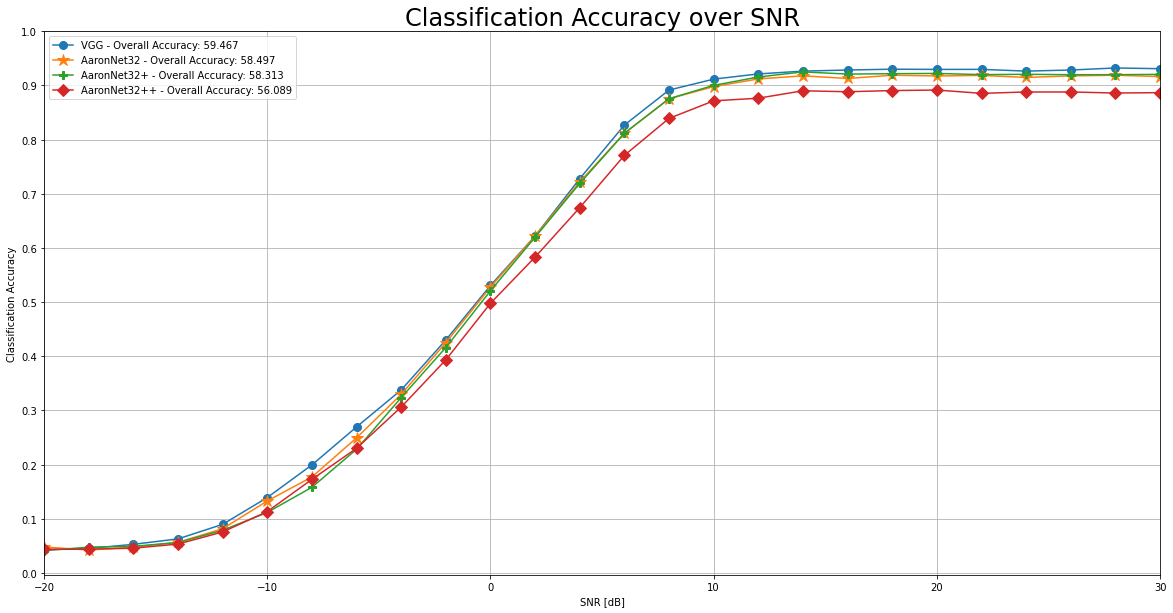

In [13]:
plt.figure(figsize=(20,10))
plt.plot(dataset.snr_classes, VGG_accs, marker='o', markersize=8)
plt.plot(dataset.snr_classes, AaronNet32_accs, marker='*', markersize=12)
plt.plot(dataset.snr_classes, AaronNet32plus_accs, marker='P', markersize=8)
plt.plot(dataset.snr_classes, AaronNet32plusplus_accs, marker='D', markersize=8)
plt.legend([
    f"VGG - Overall Accuracy: {np.mean(VGG_accs)*100:0.3f}",
    f"AaronNet32 - Overall Accuracy: {np.mean(AaronNet32_accs)*100:0.3f}",
    f"AaronNet32+ - Overall Accuracy: {np.mean(AaronNet32plus_accs)*100:0.3f}",
    f"AaronNet32++ - Overall Accuracy: {np.mean(AaronNet32plusplus_accs)*100:0.3f}"])
plt.rcParams.update({'font.size': 20})
plt.xlabel("SNR [dB]")
plt.xlim([-20, 30])
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Classification Accuracy over SNR")
plt.grid()
plt.title("Classification Accuracy over SNR")
plt.show()

## Accuracy vs SNR of AaronNet48

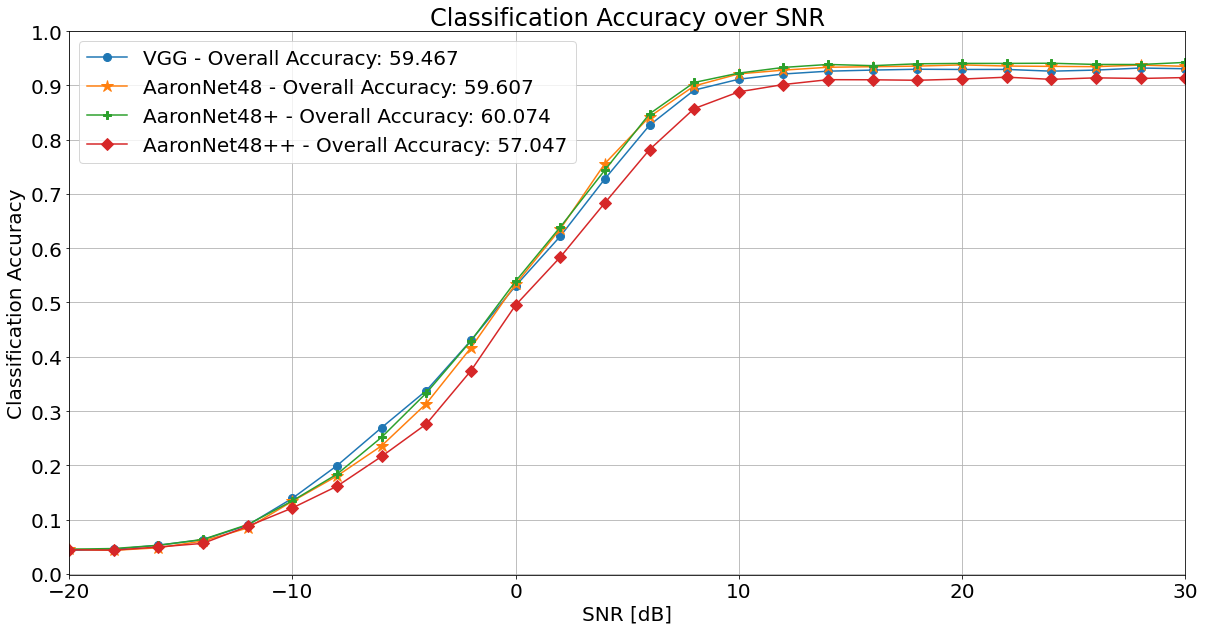

In [14]:
plt.figure(figsize=(20,10))
plt.plot(dataset.snr_classes, VGG_accs, marker='o', markersize=8)
plt.plot(dataset.snr_classes, AaronNet48_accs, marker='*', markersize=12)
plt.plot(dataset.snr_classes, AaronNet48plus_accs, marker='P', markersize=8)
plt.plot(dataset.snr_classes, AaronNet48plusplus_accs, marker='D', markersize=8)
plt.rcParams.update({'font.size': 20})
plt.legend([
    f"VGG - Overall Accuracy: {np.mean(VGG_accs)*100:0.3f}",
    f"AaronNet48 - Overall Accuracy: {np.mean(AaronNet48_accs)*100:0.3f}",
    f"AaronNet48+ - Overall Accuracy: {np.mean(AaronNet48plus_accs)*100:0.3f}",
    f"AaronNet48++ - Overall Accuracy: {np.mean(AaronNet48plusplus_accs)*100:0.3f}"
])
plt.xlabel("SNR [dB]")
plt.xlim([-20, 30])
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Classification Accuracy over SNR")
plt.grid()
plt.title("Classification Accuracy over SNR")
plt.show()

## Accuracy vs SNR of best in cases (Highest Acc, Highest Compression and Baseline)

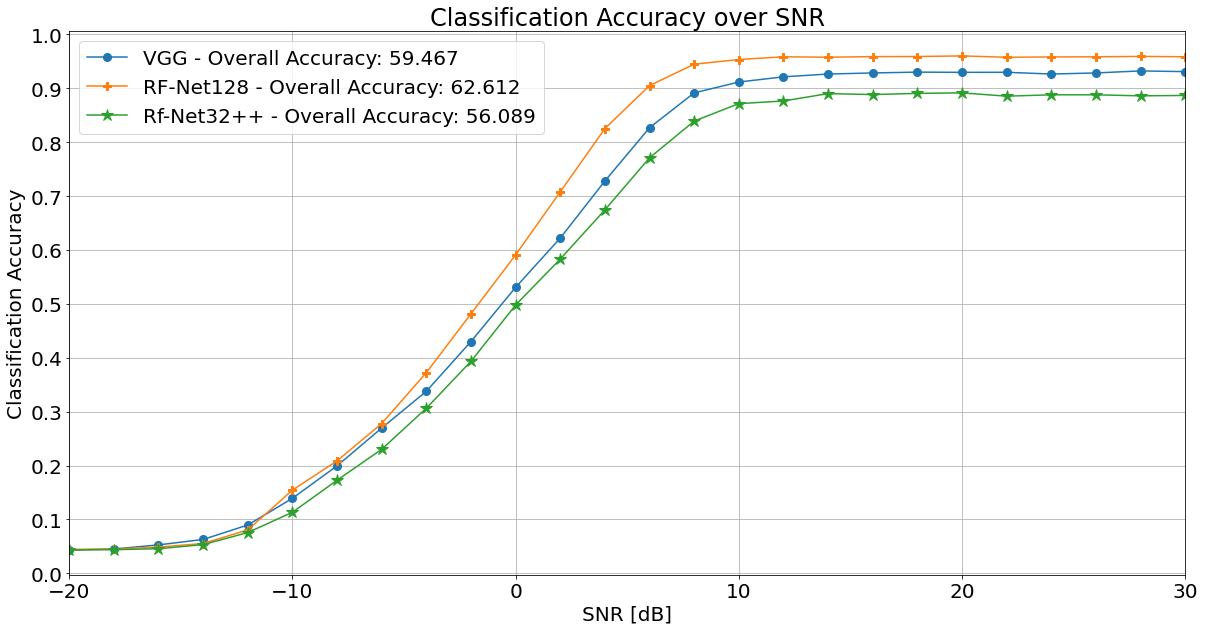

In [15]:
plt.figure(figsize=(20,10))
plt.plot(dataset.snr_classes, VGG_accs, marker='o', markersize=8)
plt.plot(dataset.snr_classes, AaronNet128_accs, marker='P', markersize=8)
plt.plot(dataset.snr_classes, AaronNet32plusplus_accs, marker='*', markersize=12)
plt.rcParams.update({'font.size': 20})
plt.legend([
    f"VGG - Overall Accuracy: {np.mean(VGG_accs)*100:0.3f}",
    f"RF-Net128 - Overall Accuracy: {np.mean(AaronNet128_accs)*100:0.3f}",
    f"Rf-Net32++ - Overall Accuracy: {np.mean(AaronNet32plusplus_accs)*100:0.3f}",
])
plt.xlabel("SNR [dB]")
plt.xlim([-20, 30])
plt.ylabel("Classification Accuracy")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.title("Classification Accuracy over SNR")
plt.grid()
plt.title("Classification Accuracy over SNR")
plt.show()

## Cost calculation of different models

In [16]:
print("VGG -- Baseline Competition")
VGGBops, VGGWBits, VGGCost = calculate_cost(VGG, "vgg")

VGG -- Baseline Competition
Inference cost for ./Models/vgg_export.onnx
{
  "discount_sparsity": true,
  "mem_o_FLOAT32": 130328.0,
  "mem_w_FLOAT32": 74112.0,
  "op_mac_FLOAT32_FLOAT32": 12864512.0,
  "total_bops": 13173260288.0,
  "total_mem_o_bits": 4170496.0,
  "total_mem_w_bits": 2371584.0,
  "unsupported": "set()"
}
Ops is 8.154798720887307, w_bits is 0.952492336955474
Normalized inference cost score: 9.107291


In [17]:
print("AaronNet32 -- Baseline")
AaronNet32Bops, AaronNet32WBits, AaronNet32Cost = calculate_cost(AaronNet32, "AaronNet32")

AaronNet32 -- Baseline
Inference cost for ./Models/AaronNet32_export.onnx
{
  "discount_sparsity": true,
  "mem_o_FLOAT32": 49275.0,
  "mem_w_FLOAT32": 7926.0,
  "op_mac_FLOAT32_FLOAT32": 1098102.0,
  "total_bops": 1124456448.0,
  "total_mem_o_bits": 1576800.0,
  "total_mem_w_bits": 253632.0,
  "unsupported": "{'GlobalMaxPool'}"
}
Ops is 0.6960855402057842, w_bits is 0.10186547742213255
Normalized inference cost score: 0.797951


In [18]:
print("AaronNet32+ -- AaronNet32 Slightly Pruned")
AaronNet32plusBops, AaronNet32plusWBits, AaronNet32plusCost = calculate_cost(AaronNet32plus, "AaronNet32plus")

AaronNet32+ -- AaronNet32 Slightly Pruned
Inference cost for ./Models/AaronNet32plus_export.onnx
{
  "discount_sparsity": true,
  "mem_o_FLOAT32": 49275.0,
  "mem_w_FLOAT32": 7926.0,
  "op_mac_FLOAT32_FLOAT32": 1098102.0,
  "total_bops": 1124456448.0,
  "total_mem_o_bits": 1576800.0,
  "total_mem_w_bits": 253632.0,
  "unsupported": "{'GlobalMaxPool'}"
}
Ops is 0.6960855402057842, w_bits is 0.10186547742213255
Normalized inference cost score: 0.797951


In [19]:
print("AaronNet32++ -- AaronNet32 Slightly Pruned")
AaronNet32plusplusBops, AaronNet32plusplusWBits, AaronNet32plusplusCost = calculate_cost(AaronNet32plusplus, "AaronNet32plusplus")

AaronNet32++ -- AaronNet32 Slightly Pruned
Inference cost for ./Models/AaronNet32plusplus_export.onnx
{
  "discount_sparsity": true,
  "mem_o_FLOAT32": 49275.0,
  "mem_w_FLOAT32": 7926.0,
  "op_mac_FLOAT32_FLOAT32": 1098102.0,
  "total_bops": 1124456448.0,
  "total_mem_o_bits": 1576800.0,
  "total_mem_w_bits": 253632.0,
  "unsupported": "{'GlobalMaxPool'}"
}
Ops is 0.6960855402057842, w_bits is 0.10186547742213255
Normalized inference cost score: 0.797951


In [20]:
print("AaronNet48 -- Baseline")
AaronNet48Bops, AaronNet48WBits, AaronNet48Cost = calculate_cost(AaronNet48, "AaronNet48")

AaronNet48 -- Baseline
Inference cost for ./Models/AaronNet48_export.onnx
{
  "discount_sparsity": true,
  "mem_o_FLOAT32": 72504.0,
  "mem_w_FLOAT32": 15440.0,
  "op_mac_FLOAT32_FLOAT32": 2044816.0,
  "total_bops": 2093891584.0,
  "total_mem_o_bits": 2320128.0,
  "total_mem_w_bits": 494080.0,
  "unsupported": "{'GlobalMaxPool'}"
}
Ops is 1.2962064088594965, w_bits is 0.1984359035323904
Normalized inference cost score: 1.494642


In [21]:
print("AaronNet48+ -- AaronNet48 Slightly Pruned")
AaronNet48plusBops, AaronNet48plusWBits, AaronNet48plusCost = calculate_cost(AaronNet48plus, "AaronNet48plus")

AaronNet48+ -- AaronNet48 Slightly Pruned
Inference cost for ./Models/AaronNet48plus_export.onnx
{
  "discount_sparsity": true,
  "mem_o_FLOAT32": 72504.0,
  "mem_w_FLOAT32": 15440.0,
  "op_mac_FLOAT32_FLOAT32": 2044816.0,
  "total_bops": 2093891584.0,
  "total_mem_o_bits": 2320128.0,
  "total_mem_w_bits": 494080.0,
  "unsupported": "{'GlobalMaxPool'}"
}
Ops is 1.2962064088594965, w_bits is 0.1984359035323904
Normalized inference cost score: 1.494642


In [22]:
print("AaronNet48++ -- AaronNet48 Highly pruned")
AaronNet48plusplusBops, AaronNet48plusplusWBits, AaronNet48plusplusCost = calculate_cost(AaronNet48plusplus, "AaronNet48plusplus")

AaronNet48++ -- AaronNet48 Highly pruned
Inference cost for ./Models/AaronNet48plusplus_export.onnx
{
  "discount_sparsity": true,
  "mem_o_FLOAT32": 72504.0,
  "mem_w_FLOAT32": 15440.0,
  "op_mac_FLOAT32_FLOAT32": 2044816.0,
  "total_bops": 2093891584.0,
  "total_mem_o_bits": 2320128.0,
  "total_mem_w_bits": 494080.0,
  "unsupported": "{'GlobalMaxPool'}"
}
Ops is 1.2962064088594965, w_bits is 0.1984359035323904
Normalized inference cost score: 1.494642


## Comparing Inference Cost

In [ ]:
all_costs = np.array([
    VGGCost, AaronNet32Cost,
    AaronNet32plusCost, AaronNet32plusplusCost,
    AaronNet48Cost, AaronNet48plusCost, AaronNet48plusplusCost
]).reshape((1, -1))

all_accs = np.array([
    np.mean(VGG_accs)*100, np.mean(AaronNet32_accs)*100,
    np.mean(AaronNet32plus_accs)*100, np.mean(AaronNet32plusplus_accs)*100,
    np.mean(AaronNet48_accs)*100, np.mean(AaronNet48plus_accs)*100, np.mean(AaronNet48plusplus_accs)*100
]).reshape(1, -1)

classes = ["VGG", "AaronNet32", "AaronNet32+", "AaronNet32++", "AaronNet48", "AaronNet48+", "AaronNet48++"]
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20, 10))
plt.title("Model Compression Ratio")
plt.ylabel("Compression Ratio")
ax = sns.barplot(x=classes, y=1.0/all_costs.reshape(-1, ))
for p in ax.patches:
    ax.annotate(f"x{np.round(p.get_height())}", (p.get_x() + 0.3, p.get_height() + 0.40))
plt.show()

## Cost vs Accuracy

In [ ]:
df = pd.DataFrame(np.vstack((all_accs, 1.0/all_costs)).T, columns=["Overall Accuracy", "Compression Ratio"])
df["Names"] = classes
df[["Names", "Overall Accuracy", "Compression Ratio"]]

# Gaining insight into sparsity 

In [ ]:
sparsity_report(VGG)

In [ ]:
sparsity_report(AaronNet48)

In [ ]:
sparsity_report(AaronNet48plus)

In [ ]:
sparsity_report(AaronNet48plusplus)

In [ ]:
sparsity_report(AaronNet32)

In [ ]:
sparsity_report(AaronNet32plus)

In [ ]:
sparsity_report(AaronNet32plusplus, True)